In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

Using TensorFlow backend.


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)


In [3]:
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

In [4]:
in_dim = 100
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=in_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(in_dim,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, in_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [8]:
def training(epochs=1, batch_size=128):
    
        #Loading the data
    batch_size=128
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size

    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, in_dim])
#             print(noise.shape)
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, in_dim])
            y_gen = np.ones(batch_size)
#             print(noise.shape,y_gen.shape)
#             print(noise[0])
#             print(y_gen[0])
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
#             print(noise.shape)
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
    generator.save("generator.h5")
    discriminator.save("discriminator.h5")
    gan.save("gan.h5")

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 2/128 [00:00<00:09, 12.72it/s]

Epoch 2


  2%|▏         | 2/128 [00:00<00:08, 14.02it/s]

Epoch 3


  2%|▏         | 2/128 [00:00<00:08, 14.47it/s]

Epoch 4


  2%|▏         | 2/128 [00:00<00:09, 13.37it/s]

Epoch 5


  2%|▏         | 2/128 [00:00<00:08, 14.27it/s]

Epoch 6


  2%|▏         | 2/128 [00:00<00:09, 13.40it/s]

Epoch 7


  2%|▏         | 2/128 [00:00<00:09, 13.44it/s]

Epoch 8


  2%|▏         | 2/128 [00:00<00:09, 13.04it/s]

Epoch 9


  2%|▏         | 2/128 [00:00<00:08, 14.02it/s]

Epoch 10


  2%|▏         | 2/128 [00:00<00:09, 13.23it/s]

Epoch 11


  2%|▏         | 2/128 [00:00<00:09, 13.47it/s]

Epoch 12


  2%|▏         | 2/128 [00:00<00:09, 13.45it/s]

Epoch 13


  2%|▏         | 2/128 [00:00<00:08, 14.50it/s]

Epoch 14


  2%|▏         | 2/128 [00:00<00:09, 13.79it/s]

Epoch 15


  2%|▏         | 2/128 [00:00<00:09, 13.54it/s]

Epoch 16


  2%|▏         | 2/128 [00:00<00:09, 13.44it/s]

Epoch 17


  2%|▏         | 2/128 [00:00<00:09, 13.26it/s]

Epoch 18


  2%|▏         | 2/128 [00:00<00:10, 11.97it/s]

Epoch 19


  2%|▏         | 2/128 [00:00<00:09, 13.15it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:09, 13.23it/s]

Epoch 21


  2%|▏         | 2/128 [00:00<00:09, 13.14it/s]

Epoch 22


  2%|▏         | 2/128 [00:00<00:09, 13.45it/s]

Epoch 23


  2%|▏         | 2/128 [00:00<00:09, 13.33it/s]

Epoch 24


  2%|▏         | 2/128 [00:00<00:09, 13.05it/s]

Epoch 25


  2%|▏         | 2/128 [00:00<00:10, 12.44it/s]

Epoch 26


  2%|▏         | 2/128 [00:00<00:08, 14.00it/s]

Epoch 27


  2%|▏         | 2/128 [00:00<00:09, 13.97it/s]

Epoch 28


  2%|▏         | 2/128 [00:00<00:09, 13.06it/s]

Epoch 29


  2%|▏         | 2/128 [00:00<00:09, 13.26it/s]

Epoch 30


  2%|▏         | 2/128 [00:00<00:09, 12.85it/s]

Epoch 31


  2%|▏         | 2/128 [00:00<00:09, 13.91it/s]

Epoch 32


  2%|▏         | 2/128 [00:00<00:09, 13.65it/s]

Epoch 33


  2%|▏         | 2/128 [00:00<00:09, 13.85it/s]

Epoch 34


  2%|▏         | 2/128 [00:00<00:09, 13.18it/s]

Epoch 35


  2%|▏         | 2/128 [00:00<00:09, 13.59it/s]

Epoch 36


  2%|▏         | 2/128 [00:00<00:10, 12.33it/s]

Epoch 37


  2%|▏         | 2/128 [00:00<00:09, 13.63it/s]

Epoch 38


  2%|▏         | 2/128 [00:00<00:09, 13.57it/s]

Epoch 39


  2%|▏         | 2/128 [00:00<00:08, 14.05it/s]

Epoch 40


  2%|▏         | 2/128 [00:00<00:09, 13.77it/s]

Epoch 41


  2%|▏         | 2/128 [00:00<00:09, 13.56it/s]

Epoch 42


  2%|▏         | 2/128 [00:00<00:10, 11.95it/s]

Epoch 43


  2%|▏         | 2/128 [00:00<00:09, 13.66it/s]

Epoch 44


  2%|▏         | 2/128 [00:00<00:08, 14.12it/s]

Epoch 45


  2%|▏         | 2/128 [00:00<00:09, 13.34it/s]

Epoch 46


  2%|▏         | 2/128 [00:00<00:09, 13.65it/s]

Epoch 47


  2%|▏         | 2/128 [00:00<00:09, 13.11it/s]

Epoch 48


  2%|▏         | 2/128 [00:00<00:11, 10.90it/s]

Epoch 49


  2%|▏         | 2/128 [00:00<00:10, 12.33it/s]

Epoch 50


  2%|▏         | 2/128 [00:00<00:09, 13.55it/s]

Epoch 51


  2%|▏         | 2/128 [00:00<00:09, 12.92it/s]

Epoch 52


  2%|▏         | 2/128 [00:00<00:09, 13.64it/s]

Epoch 53


  2%|▏         | 2/128 [00:00<00:10, 12.58it/s]

Epoch 54


  2%|▏         | 2/128 [00:00<00:09, 13.57it/s]

Epoch 55


  2%|▏         | 2/128 [00:00<00:09, 13.11it/s]

Epoch 56


  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]

Epoch 57


  2%|▏         | 2/128 [00:00<00:10, 12.56it/s]

Epoch 58


  2%|▏         | 2/128 [00:00<00:09, 13.37it/s]

Epoch 59


  2%|▏         | 2/128 [00:00<00:09, 13.95it/s]

Epoch 60


  2%|▏         | 2/128 [00:00<00:10, 12.17it/s]

Epoch 61


  2%|▏         | 2/128 [00:00<00:09, 13.80it/s]

Epoch 62


  2%|▏         | 2/128 [00:00<00:09, 13.93it/s]

Epoch 63


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 64


  2%|▏         | 2/128 [00:00<00:09, 13.42it/s]

Epoch 65


  2%|▏         | 2/128 [00:00<00:08, 14.17it/s]

Epoch 66


  2%|▏         | 2/128 [00:00<00:09, 13.93it/s]

Epoch 67


  2%|▏         | 2/128 [00:00<00:09, 13.81it/s]

Epoch 68


  2%|▏         | 2/128 [00:00<00:09, 12.74it/s]

Epoch 69


  2%|▏         | 2/128 [00:00<00:09, 13.13it/s]

Epoch 70


  2%|▏         | 2/128 [00:00<00:09, 13.60it/s]

Epoch 71


  2%|▏         | 2/128 [00:00<00:09, 13.24it/s]

Epoch 72


  2%|▏         | 2/128 [00:00<00:10, 11.89it/s]

Epoch 73


  2%|▏         | 2/128 [00:00<00:09, 12.95it/s]

Epoch 74


  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]

Epoch 75


  2%|▏         | 2/128 [00:00<00:09, 13.56it/s]

Epoch 76


  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]

Epoch 77


  2%|▏         | 2/128 [00:00<00:09, 13.33it/s]

Epoch 78


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 79


  2%|▏         | 2/128 [00:00<00:09, 13.91it/s]

Epoch 80


  2%|▏         | 2/128 [00:00<00:09, 13.20it/s]

Epoch 81


  2%|▏         | 2/128 [00:00<00:09, 13.08it/s]

Epoch 82


  2%|▏         | 2/128 [00:00<00:09, 13.59it/s]

Epoch 83


  2%|▏         | 2/128 [00:00<00:09, 13.53it/s]

Epoch 84


  2%|▏         | 2/128 [00:00<00:10, 11.63it/s]

Epoch 85


  2%|▏         | 2/128 [00:00<00:09, 12.70it/s]

Epoch 86


  2%|▏         | 2/128 [00:00<00:09, 13.96it/s]

Epoch 87


  2%|▏         | 2/128 [00:00<00:09, 13.83it/s]

Epoch 88


  2%|▏         | 2/128 [00:00<00:10, 12.42it/s]

Epoch 89


  2%|▏         | 2/128 [00:00<00:09, 12.78it/s]

Epoch 90


  2%|▏         | 2/128 [00:00<00:09, 13.25it/s]

Epoch 91


  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]

Epoch 92


  2%|▏         | 2/128 [00:00<00:09, 13.13it/s]

Epoch 93


  2%|▏         | 2/128 [00:00<00:09, 13.85it/s]

Epoch 94


  2%|▏         | 2/128 [00:00<00:09, 13.55it/s]

Epoch 95


  2%|▏         | 2/128 [00:00<00:09, 13.28it/s]

Epoch 96


  2%|▏         | 2/128 [00:00<00:09, 13.79it/s]

Epoch 97


  1%|          | 1/128 [00:00<00:13,  9.59it/s]

Epoch 98


  2%|▏         | 2/128 [00:00<00:09, 13.57it/s]

Epoch 99


  2%|▏         | 2/128 [00:00<00:08, 14.05it/s]

Epoch 100


  2%|▏         | 2/128 [00:00<00:09, 12.94it/s]

Epoch 101


  2%|▏         | 2/128 [00:00<00:09, 13.59it/s]

Epoch 102


  2%|▏         | 2/128 [00:00<00:09, 13.28it/s]

Epoch 103


  2%|▏         | 2/128 [00:00<00:08, 14.28it/s]

Epoch 104


  2%|▏         | 2/128 [00:00<00:09, 13.51it/s]

Epoch 105


  2%|▏         | 2/128 [00:00<00:09, 13.66it/s]

Epoch 106


  2%|▏         | 2/128 [00:00<00:09, 13.18it/s]

Epoch 107


  2%|▏         | 2/128 [00:00<00:09, 13.36it/s]

Epoch 108


  2%|▏         | 2/128 [00:00<00:09, 13.75it/s]

Epoch 109


  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]

Epoch 110


  2%|▏         | 2/128 [00:00<00:09, 13.76it/s]

Epoch 111


  2%|▏         | 2/128 [00:00<00:09, 13.02it/s]

Epoch 112


  2%|▏         | 2/128 [00:00<00:09, 13.93it/s]

Epoch 113


  2%|▏         | 2/128 [00:00<00:09, 13.89it/s]

Epoch 114


  2%|▏         | 2/128 [00:00<00:09, 13.98it/s]

Epoch 115


  2%|▏         | 2/128 [00:00<00:09, 13.35it/s]

Epoch 116


  2%|▏         | 2/128 [00:00<00:09, 13.97it/s]

Epoch 117


  2%|▏         | 2/128 [00:00<00:09, 13.84it/s]

Epoch 118


  2%|▏         | 2/128 [00:00<00:09, 14.00it/s]

Epoch 119


  2%|▏         | 2/128 [00:00<00:09, 13.82it/s]

Epoch 120


  2%|▏         | 2/128 [00:00<00:09, 12.60it/s]

Epoch 121


  2%|▏         | 2/128 [00:00<00:09, 13.61it/s]

Epoch 122


  2%|▏         | 2/128 [00:00<00:09, 13.41it/s]

Epoch 123


  2%|▏         | 2/128 [00:00<00:09, 13.94it/s]

Epoch 124


  2%|▏         | 2/128 [00:00<00:09, 13.10it/s]

Epoch 125


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 126


  2%|▏         | 2/128 [00:00<00:09, 13.45it/s]

Epoch 127


  2%|▏         | 2/128 [00:00<00:08, 14.10it/s]

Epoch 128


  2%|▏         | 2/128 [00:00<00:09, 13.77it/s]

Epoch 129


  2%|▏         | 2/128 [00:00<00:10, 12.58it/s]

Epoch 130


  2%|▏         | 2/128 [00:00<00:09, 13.55it/s]

Epoch 131


  2%|▏         | 2/128 [00:00<00:08, 14.45it/s]

Epoch 132


  2%|▏         | 2/128 [00:00<00:09, 13.82it/s]

Epoch 133


  2%|▏         | 2/128 [00:00<00:08, 14.18it/s]

Epoch 134


  2%|▏         | 2/128 [00:00<00:09, 13.95it/s]

Epoch 135


  2%|▏         | 2/128 [00:00<00:09, 13.35it/s]

Epoch 136


  2%|▏         | 2/128 [00:00<00:09, 13.53it/s]

Epoch 137


  2%|▏         | 2/128 [00:00<00:09, 13.41it/s]

Epoch 138


  2%|▏         | 2/128 [00:00<00:09, 13.99it/s]

Epoch 139


  2%|▏         | 2/128 [00:00<00:09, 13.72it/s]

Epoch 140


  2%|▏         | 2/128 [00:00<00:09, 13.01it/s]

Epoch 141


  2%|▏         | 2/128 [00:00<00:09, 13.12it/s]

Epoch 142


  2%|▏         | 2/128 [00:00<00:08, 14.25it/s]

Epoch 143


  2%|▏         | 2/128 [00:00<00:09, 13.49it/s]

Epoch 144


  2%|▏         | 2/128 [00:00<00:11, 10.98it/s]

Epoch 145


  2%|▏         | 2/128 [00:00<00:11, 10.80it/s]

Epoch 146


  2%|▏         | 2/128 [00:00<00:09, 13.12it/s]

Epoch 147


  2%|▏         | 2/128 [00:00<00:09, 13.97it/s]

Epoch 148


  2%|▏         | 2/128 [00:00<00:09, 13.54it/s]

Epoch 149


  2%|▏         | 2/128 [00:00<00:09, 13.53it/s]

Epoch 150


  2%|▏         | 2/128 [00:00<00:09, 13.73it/s]

Epoch 151


  2%|▏         | 2/128 [00:00<00:09, 13.11it/s]

Epoch 152


  2%|▏         | 2/128 [00:00<00:09, 13.75it/s]

Epoch 153


  2%|▏         | 2/128 [00:00<00:09, 13.27it/s]

Epoch 154


  2%|▏         | 2/128 [00:00<00:09, 13.70it/s]

Epoch 155


  2%|▏         | 2/128 [00:00<00:09, 13.88it/s]

Epoch 156


  2%|▏         | 2/128 [00:00<00:08, 14.18it/s]

Epoch 157


  2%|▏         | 2/128 [00:00<00:11, 10.93it/s]

Epoch 158


  2%|▏         | 2/128 [00:00<00:09, 12.60it/s]

Epoch 159


  2%|▏         | 2/128 [00:00<00:09, 13.57it/s]

Epoch 160


  2%|▏         | 2/128 [00:00<00:08, 14.04it/s]

Epoch 161


  2%|▏         | 2/128 [00:00<00:09, 13.74it/s]

Epoch 162


  2%|▏         | 2/128 [00:00<00:09, 13.80it/s]

Epoch 163


  2%|▏         | 2/128 [00:00<00:09, 13.40it/s]

Epoch 164


  2%|▏         | 2/128 [00:00<00:08, 14.19it/s]

Epoch 165


  2%|▏         | 2/128 [00:00<00:09, 13.40it/s]

Epoch 166


  2%|▏         | 2/128 [00:00<00:10, 12.34it/s]

Epoch 167


  2%|▏         | 2/128 [00:00<00:09, 13.45it/s]

Epoch 168


  2%|▏         | 2/128 [00:00<00:09, 13.45it/s]

Epoch 169


  2%|▏         | 2/128 [00:00<00:09, 13.19it/s]

Epoch 170


  2%|▏         | 2/128 [00:00<00:09, 13.56it/s]

Epoch 171


  2%|▏         | 2/128 [00:00<00:09, 13.22it/s]

Epoch 172


  2%|▏         | 2/128 [00:00<00:08, 14.01it/s]

Epoch 173


  2%|▏         | 2/128 [00:00<00:09, 12.80it/s]

Epoch 174


  2%|▏         | 2/128 [00:00<00:09, 13.46it/s]

Epoch 175


  2%|▏         | 2/128 [00:00<00:09, 13.71it/s]

Epoch 176


  2%|▏         | 2/128 [00:00<00:09, 13.29it/s]

Epoch 177


  2%|▏         | 2/128 [00:00<00:09, 13.35it/s]

Epoch 178


  2%|▏         | 2/128 [00:00<00:09, 13.70it/s]

Epoch 179


  2%|▏         | 2/128 [00:00<00:09, 13.50it/s]

Epoch 180


  2%|▏         | 2/128 [00:00<00:09, 13.63it/s]

Epoch 181


  2%|▏         | 2/128 [00:00<00:10, 11.75it/s]

Epoch 182


  2%|▏         | 2/128 [00:00<00:09, 13.84it/s]

Epoch 183


  2%|▏         | 2/128 [00:00<00:10, 12.54it/s]

Epoch 184


  2%|▏         | 2/128 [00:00<00:09, 13.26it/s]

Epoch 185


  2%|▏         | 2/128 [00:00<00:09, 13.25it/s]

Epoch 186


  2%|▏         | 2/128 [00:00<00:09, 13.70it/s]

Epoch 187


  2%|▏         | 2/128 [00:00<00:08, 14.25it/s]

Epoch 188


  1%|          | 1/128 [00:00<00:14,  8.91it/s]

Epoch 189


  2%|▏         | 2/128 [00:00<00:09, 13.23it/s]

Epoch 190


  2%|▏         | 2/128 [00:00<00:11, 10.95it/s]

Epoch 191


  2%|▏         | 2/128 [00:00<00:08, 14.22it/s]

Epoch 192


  2%|▏         | 2/128 [00:00<00:09, 13.13it/s]

Epoch 193


  2%|▏         | 2/128 [00:00<00:08, 14.05it/s]

Epoch 194


  2%|▏         | 2/128 [00:00<00:09, 13.22it/s]

Epoch 195


  2%|▏         | 2/128 [00:00<00:09, 13.33it/s]

Epoch 196


  2%|▏         | 2/128 [00:00<00:08, 14.12it/s]

Epoch 197


  2%|▏         | 2/128 [00:00<00:09, 12.99it/s]

Epoch 198


  2%|▏         | 2/128 [00:00<00:09, 13.41it/s]

Epoch 199


  2%|▏         | 2/128 [00:00<00:09, 13.41it/s]

Epoch 200


100%|██████████| 128/128 [00:09<00:00, 13.15it/s]


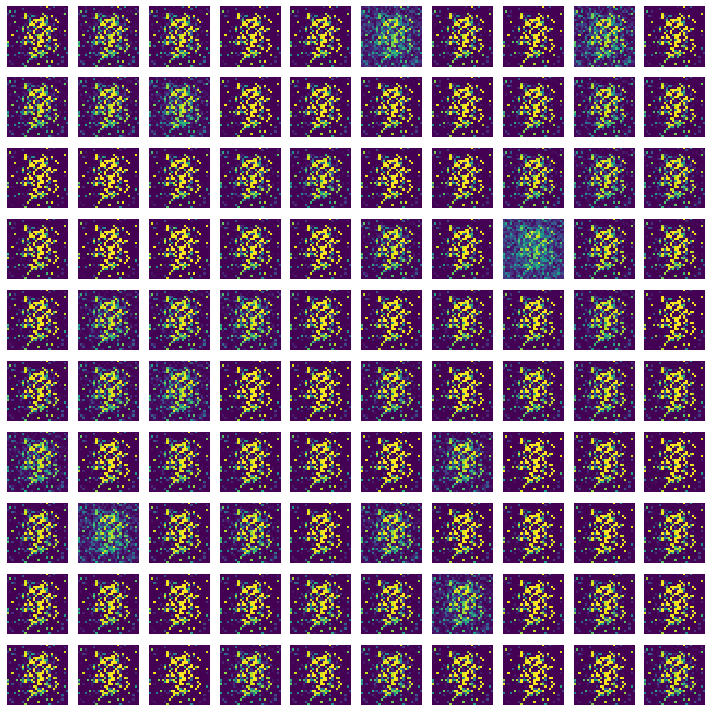

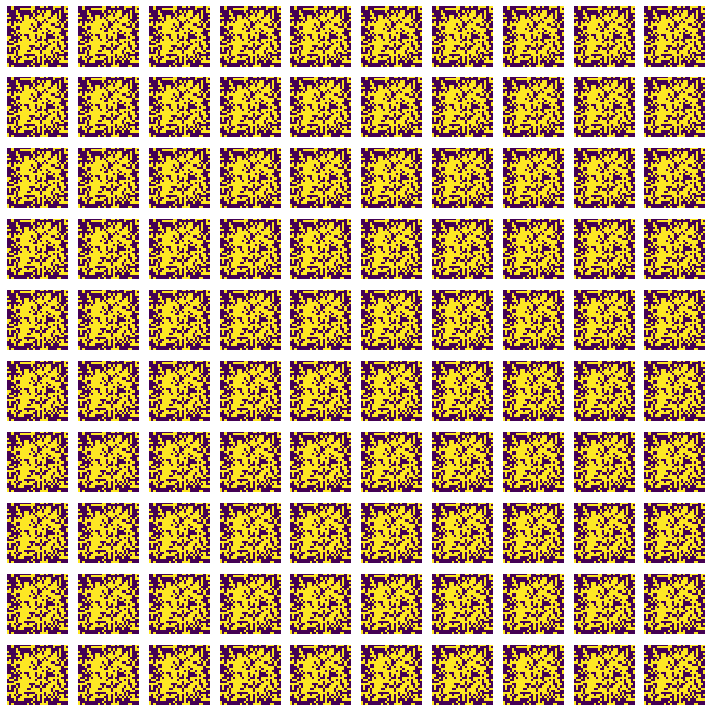

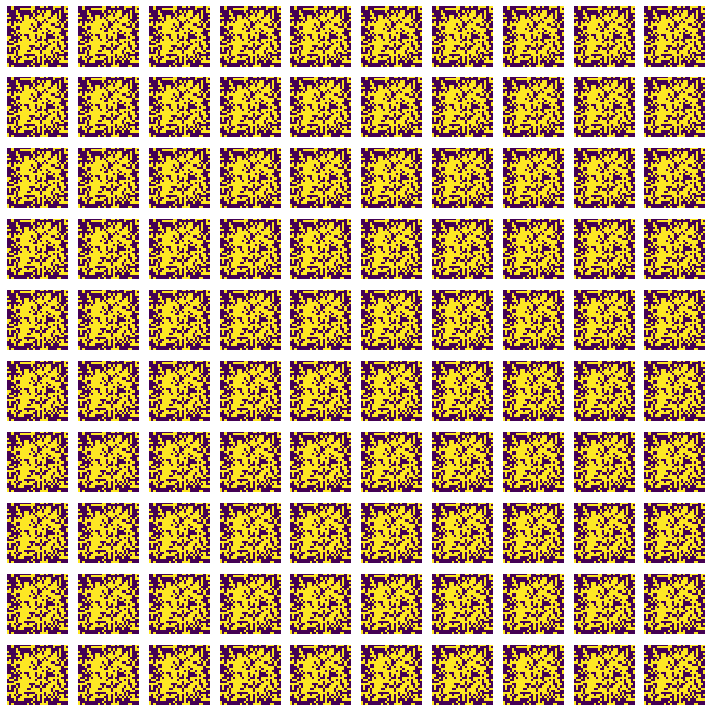

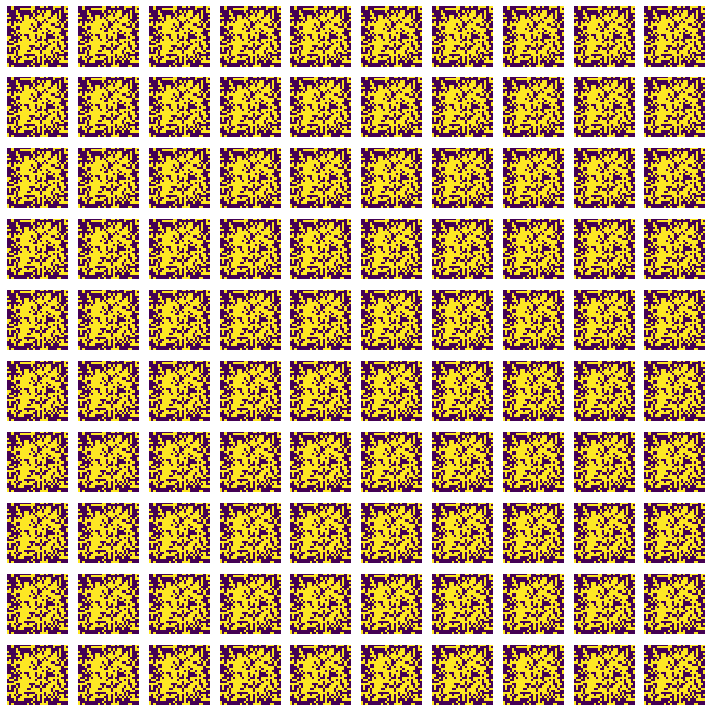

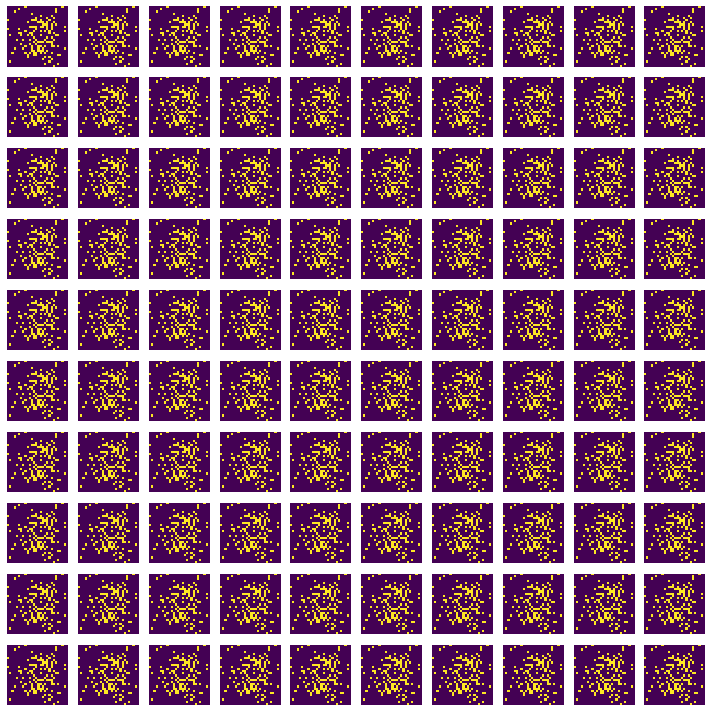

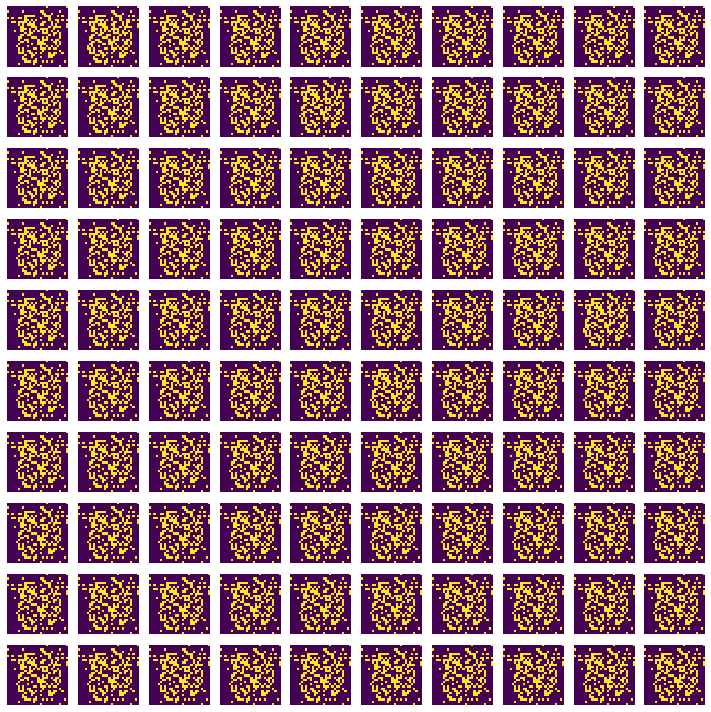

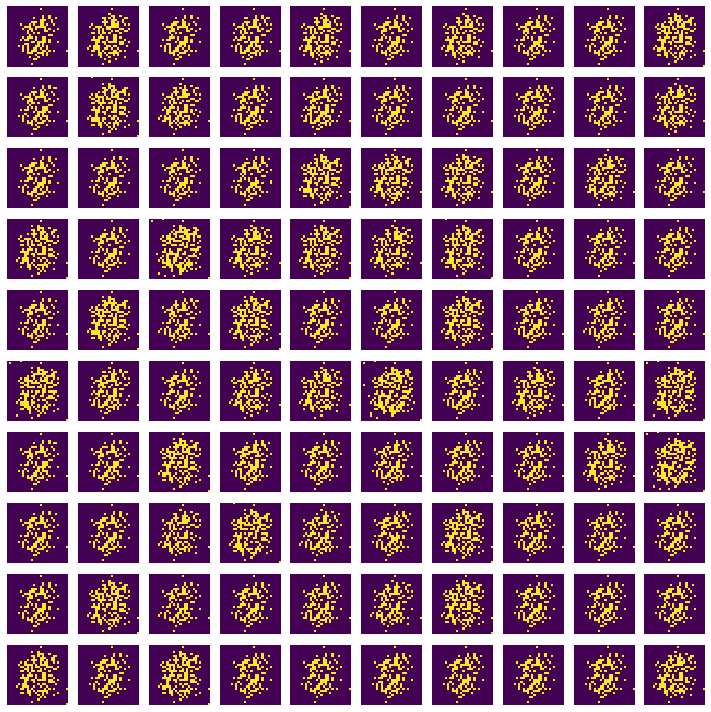

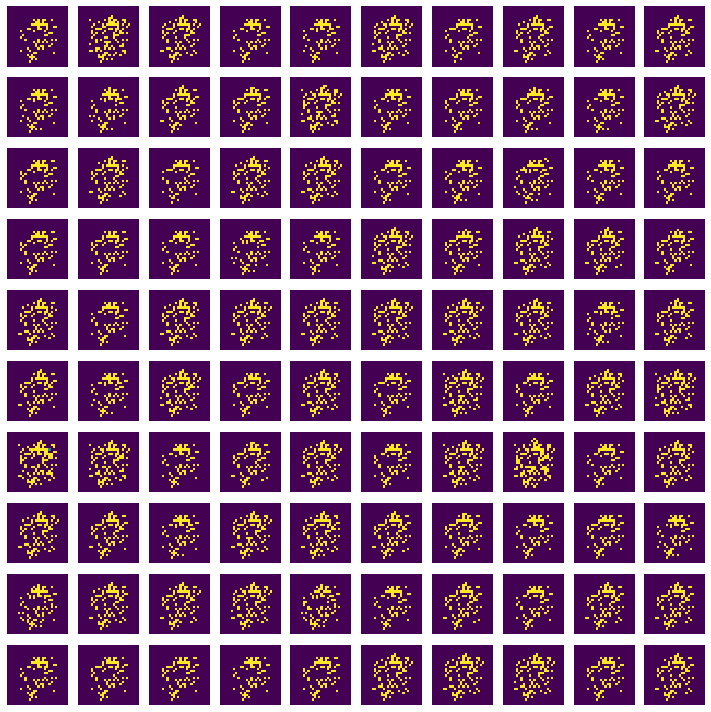

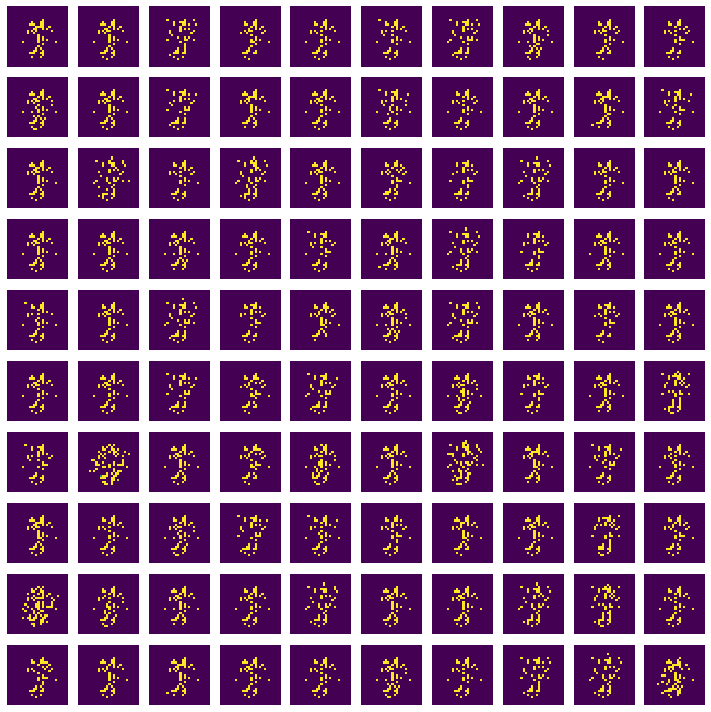

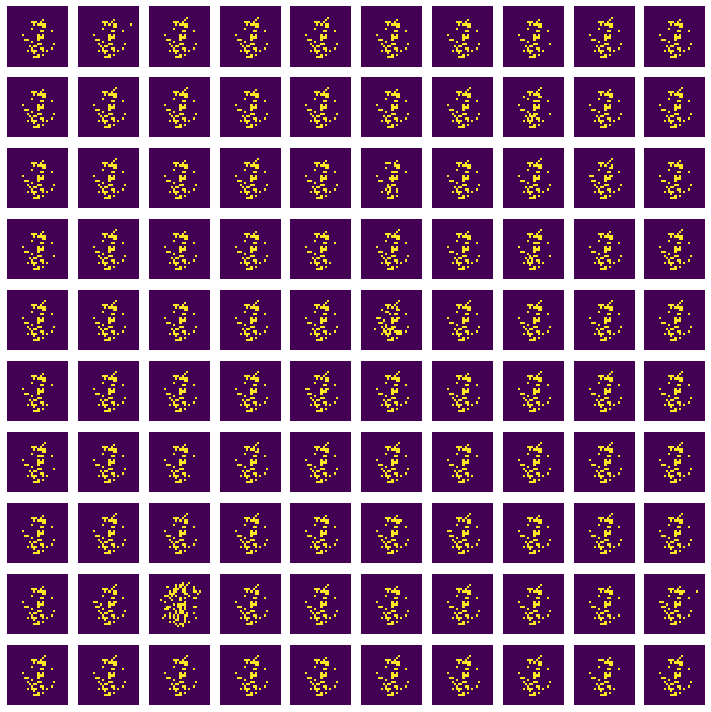

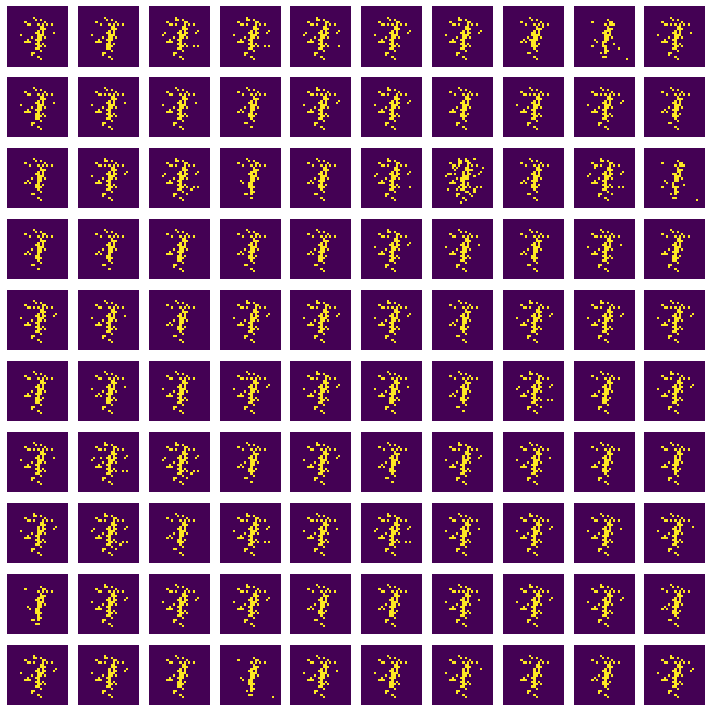

In [9]:
training(200,1024)